In [1]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
path_to_project = path_to_this_notebook[:path_to_this_notebook.find('note')]
sys.path.append(path_to_project)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
path_to_data = path_to_project + '/data/elaadnl/'
df = pd.read_excel(io=path_to_data + 'elaadnl_open_ev_datasets.xlsx', sheet_name='open_transactions')

date_start = df['UTCTransactionStart'].apply(lambda x: str(x.date()))
date_end = df['UTCTransactionStop'].apply(lambda x: str(x.date()))
time_start = df['UTCTransactionStart'].apply(lambda x: str(x.time().replace(second=0))[:-3])
time_end = df['UTCTransactionStop'].apply(lambda x: str(x.time().replace(second=0))[:-3])

df['date_start'] = date_start
df['date_end'] = date_end
df['time_start'] = time_start
df['time_end'] = time_end
df = df.rename(columns={'ConnectedTime': 'duration', 'TotalEnergy': 'charged'}, )
df = df[['date_start', 'time_start', 'date_end', 'time_end', 'duration', 'charged']]
mask_keep = ~(df['duration'] > 24)
df = df[mask_keep].reset_index(drop=True)
df.head()

,date_start,time_start,date_end,time_end,duration,charged
0,2019-08-27,14:52,2019-08-27,17:58,3.11,9.86
1,2019-03-01,10:14,2019-03-01,13:13,3.00,9.38
2,2019-07-31,12:54,2019-07-31,13:21,0.46,1.45
3,2019-06-16,10:55,2019-06-16,14:35,3.65,38.77
4,2019-03-07,21:21,2019-03-08,07:22,10.03,26.14


In [75]:
df.to_csv(path_to_data + '/charging_sessions.csv', index=None)

In [3]:
def minutes_to_time_string(minutes):
    hrs = minutes // 60
    mins = minutes - hrs * 60
    return ('0%d:' % hrs if hrs < 10 else '%d:' % hrs) + ('0%d' % mins if mins < 10 else '%d' % mins)
dt = 1
df_rescaled = df.copy()
rescaling_map = {minutes_to_time_string(i * dt + j): minutes_to_time_string(i * dt)
                         for i in range(int(24 * 60 / dt)) for j in range(dt)}
all_times_hr = np.arange(0, 24, dt/60)
all_times_str = [minutes_to_time_string(np.round(t * 60)) for t in all_times_hr]
df_rescaled['time_start'] =  df['time_start'].apply(lambda x: rescaling_map[x])
df_rescaled['time_end'] =  df['time_end'].apply(lambda x: rescaling_map[x])

In [7]:
value_counts_dict = df_rescaled['time_start'].value_counts()
x, y = [], []
for t in sorted(all_times_str): 
    x.append(t)
    val = max(1, value_counts_dict[t] if t in value_counts_dict else 0)
    y.append(val)
#y_filtered = savgol_filter(y, 11, 5)

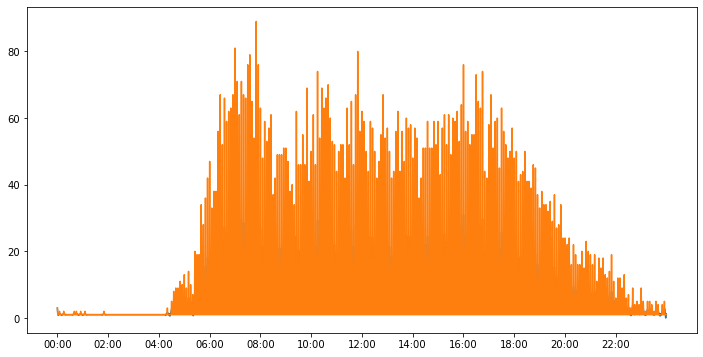

In [122]:
from scipy.signal import savgol_filter
_ = plt.figure(figsize=(12, 6))
_ = plt.plot(x, y_filtered)
_ = plt.plot(x, y)
_ = plt.xticks(x[::120])

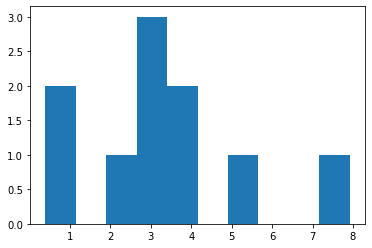

In [125]:
t = '12:00'
df_t  = df_rescaled[df_rescaled['time_start'] == t]
dur = df_t['duration']
p = df_t['charged']

_ = plt.hist(dur)

In [14]:
metadata_dict = {'arrival_counts': {xi: yi for xi, yi in zip(x, y)}, }

In [16]:
with open(path_to_data + 'metadata_dict.pickle', 'wb') as f:
    pickle.dump(metadata_dict, f, protocol=pickle.HIGHEST_PROTOCOL)